In [1]:
import scanpy as sc
from sklearn.preprocessing import LabelEncoder
from scvi.dataset import AnnDatasetFromAnnData
from scvi.models import *
from scvi.inference import UnsupervisedTrainer
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scvi.models.vae import VAE
import numpy as np
import surgeon

[2019-09-05 11:20:18,213] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.
/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
Using TensorFlow backend.


In [2]:
sc.settings.set_figure_params(dpi=200)

In [3]:
condition_key = 'study'
cell_type_key = 'cell_type'
target_conditions = ["Rosenberg", "Zeisel"]

In [4]:
adata = sc.read("data/mouse_brain_subset/mouse_brain_subset_count.h5ad")
adata = adata[adata.obs[condition_key].isin(target_conditions)]
adata

View of AnnData object with n_obs × n_vars = 19556 × 14858 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster'
    uns: 'cell_type_colors', 'neighbors', 'study_colors'
    obsm: 'X_pca', 'X_umap'

In [5]:
adata_normalized = adata.copy()

In [6]:
adata_normalized = surgeon.utils.normalize(adata_normalized,
                                           filter_min_counts=False,
                                           normalize_input=False,
                                           logtrans_input=True,
                                           size_factors=True,
                                           n_top_genes=2000)

In [7]:
adata_normalized

AnnData object with n_obs × n_vars = 19556 × 2000 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster', 'n_counts', 'size_factors'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'neighbors', 'study_colors'
    obsm: 'X_pca', 'X_umap'

In [8]:
adata = adata[:, adata_normalized.var_names]
adata

View of AnnData object with n_obs × n_vars = 19556 × 2000 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster'
    uns: 'cell_type_colors', 'neighbors', 'study_colors'
    obsm: 'X_pca', 'X_umap'

In [9]:
adata.X.min(), adata.X.max()

(0.0, 5586.0)

In [10]:
adata.obs.groupby([cell_type_key, condition_key]).size()

cell_type                       study    
astrocyte                       Rosenberg     736
                                Zeisel       1387
brain pericyte                  Rosenberg      67
                                Zeisel        358
endothelial cell                Rosenberg      30
                                Zeisel        532
ependymal cell                  Rosenberg      18
                                Zeisel         86
macrophage                      Rosenberg       4
                                Zeisel        138
microglial cell                 Rosenberg      27
                                Zeisel        378
neuron                          Rosenberg    8012
                                Zeisel       5029
olfactory ensheathing cell      Rosenberg      22
                                Zeisel        154
oligodendrocyte                 Rosenberg     120
                                Zeisel       2095
oligodendrocyte precursor cell  Rosenberg     304
        

In [11]:
adata.obs['labels'] = LabelEncoder().fit_transform(adata.obs[cell_type_key])
adata.obs['batch_indices'] = LabelEncoder().fit_transform(adata.obs[condition_key])

Trying to set attribute `.obs` of view, making a copy.


In [12]:
adata.obs['labels'].value_counts()

6    13041
8     2215
0     2123
2      562
1      425
5      405
9      363
7      176
4      142
3      104
Name: labels, dtype: int64

In [13]:
adata.obs['batch_indices'].value_counts()

1    10216
0     9340
Name: batch_indices, dtype: int64

In [14]:
scvi_adata = AnnDatasetFromAnnData(adata)
scvi_adata

[2019-09-05 11:20:44,151] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2019-09-05 11:20:44,280] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-09-05 11:20:44,282] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-09-05 11:20:44,338] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-09-05 11:20:44,397] INFO - scvi.dataset.dataset | Downsampled from 19556 to 19556 cells


GeneExpressionDataset object with n_cells x nb_genes = 19556 x 2000
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'labels', 'batch_indices', 'local_vars', 'local_means'
    cell_categorical_attribute_names: 'labels', 'batch_indices'

In [15]:
scvi_adata.n_labels, scvi_adata.n_batches

(10, 2)

In [16]:
np.unique(scvi_adata.batch_indices)

array([0, 1], dtype=uint16)

In [17]:
np.unique(scvi_adata.labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint16)

## Creating the Model

In [18]:
n_epochs = 300
lr = 1e-3
use_batches = True
n_samples = adata.shape[0]

In [19]:
vae = VAE(scvi_adata.nb_genes, n_batch=scvi_adata.n_batches * use_batches)
trainer = UnsupervisedTrainer(
    vae,
    scvi_adata,
    train_size=0.8,
    use_cuda=True,
    frequency=1,
)

In [20]:
trainer.train(n_epochs=n_epochs, lr=lr)

training: 100%|██████████| 300/300 [06:12<00:00,  1.21s/it]


In [22]:
trainer.train_set.reconstruction_error()

345.2584591511722

In [23]:
trainer.history.keys()

dict_keys(['elbo_train_set', 'elbo_test_set'])

In [24]:
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]

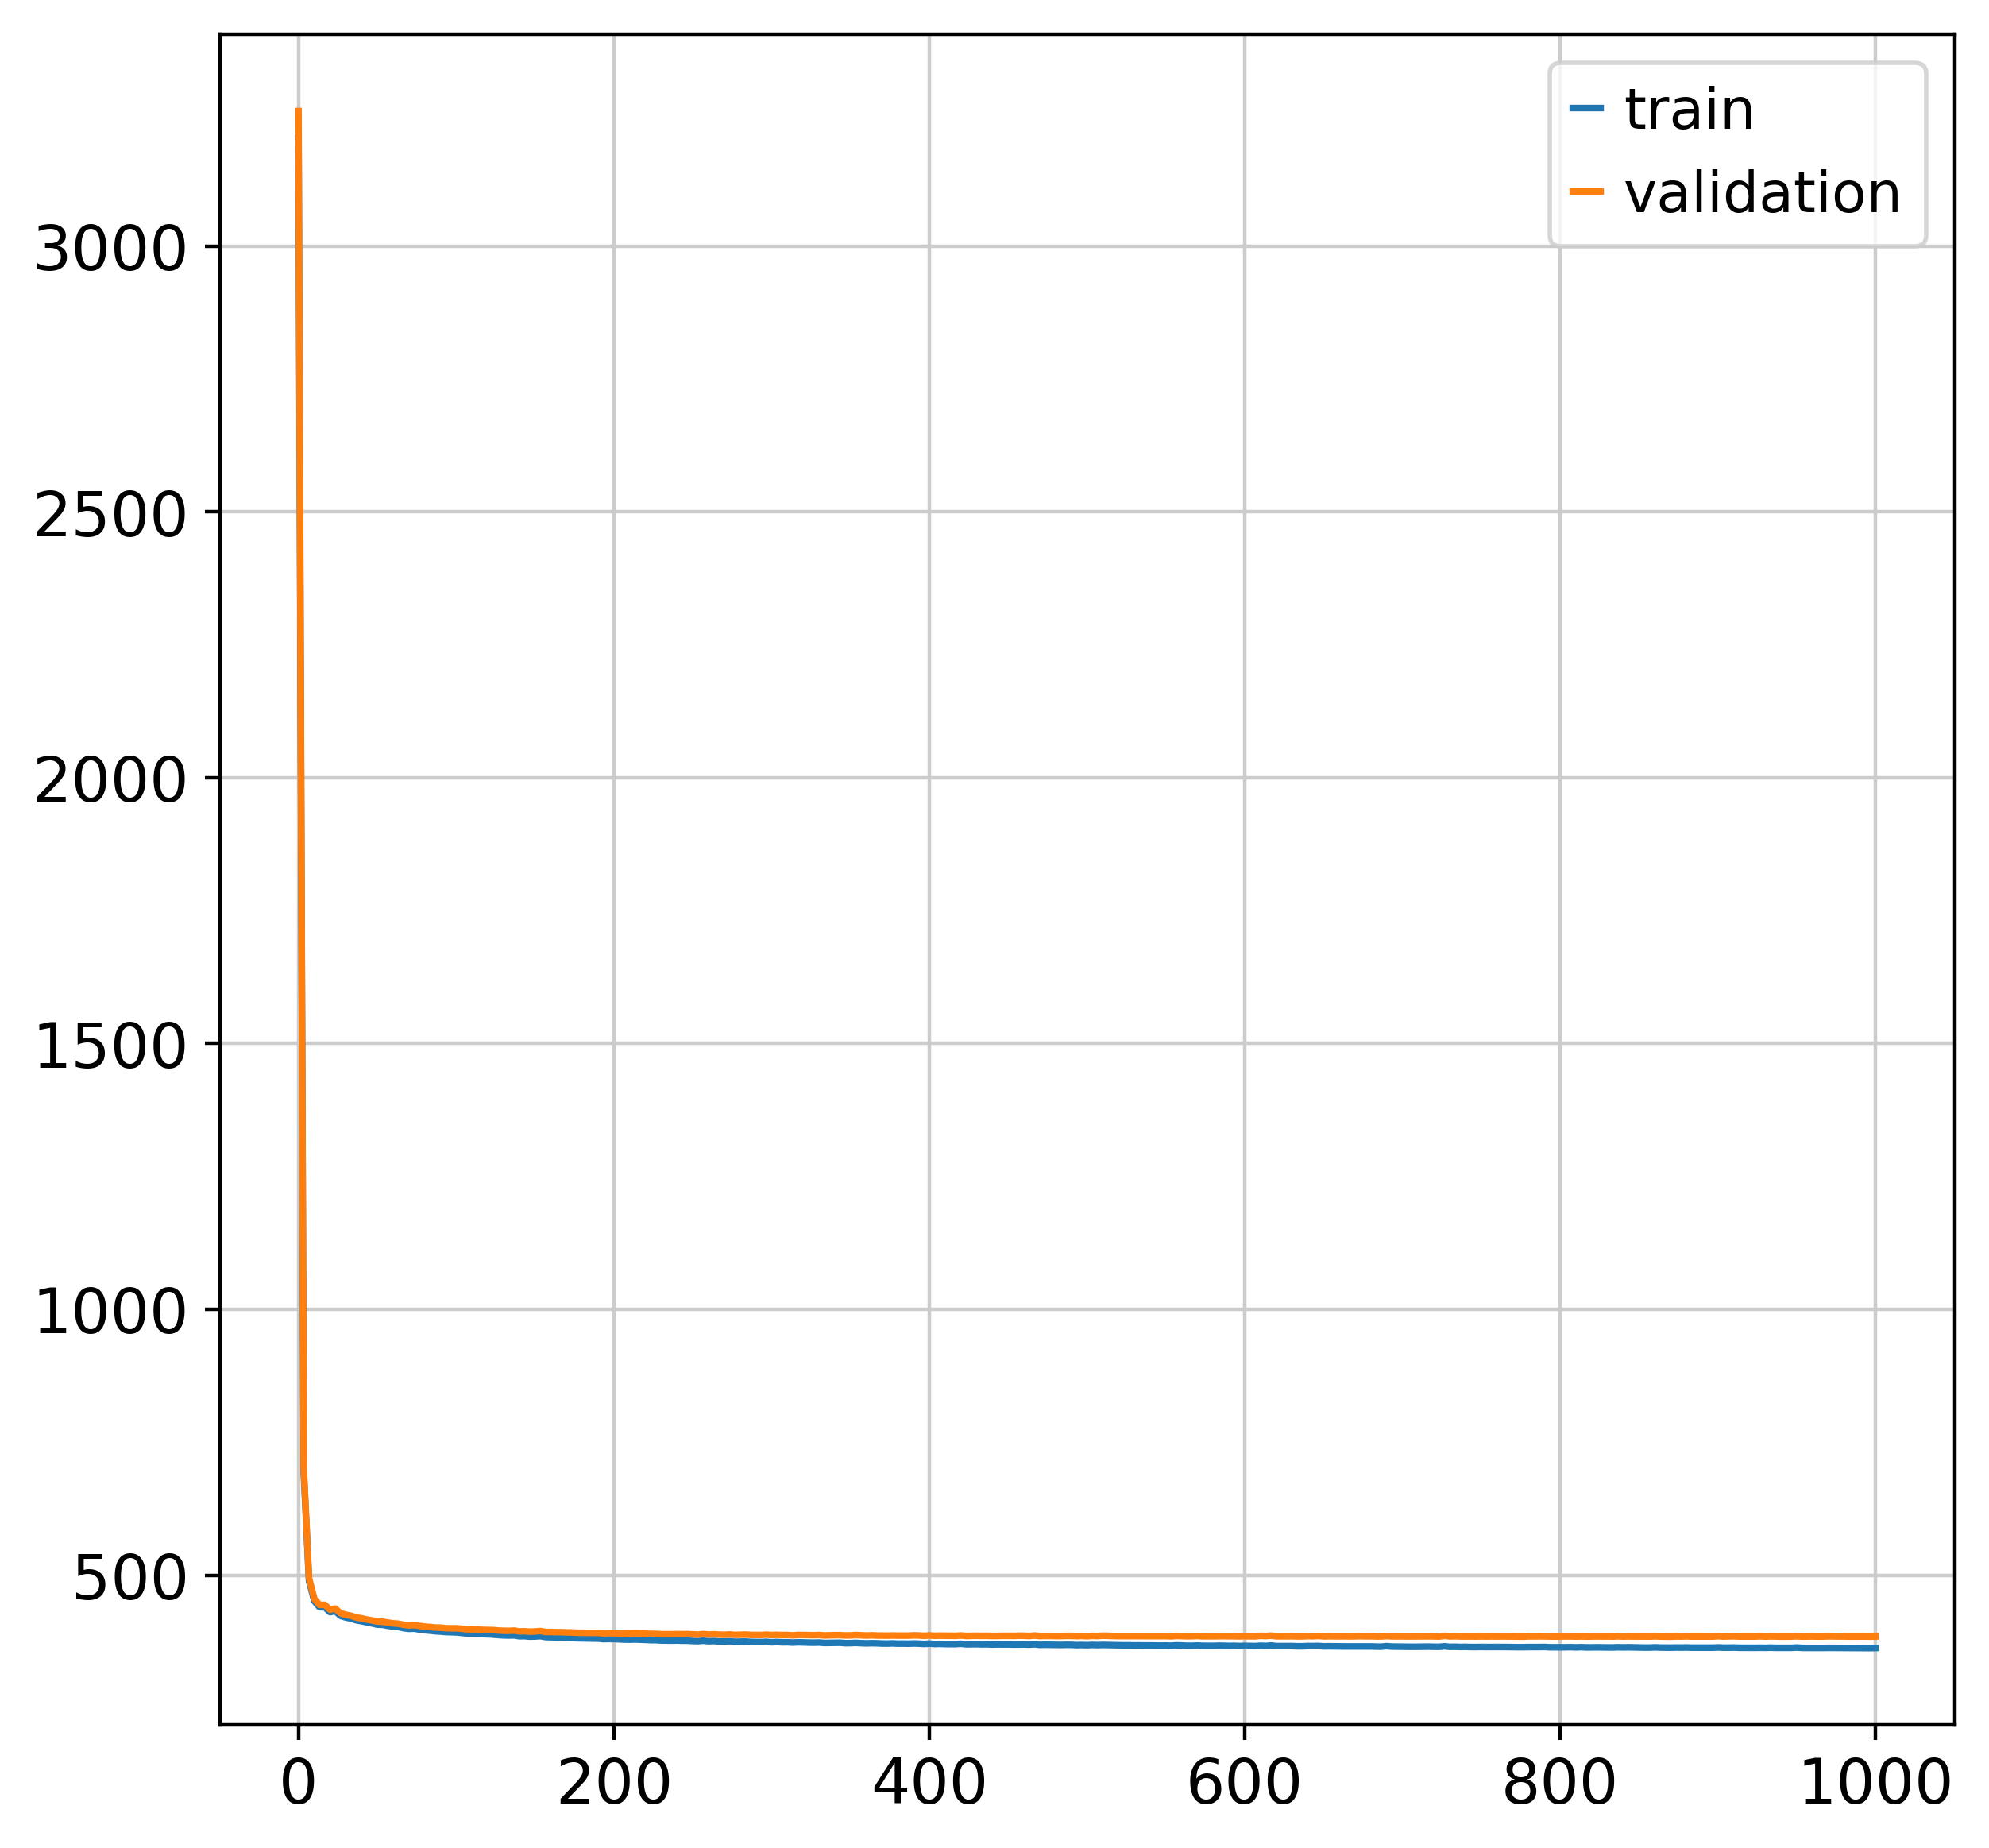

In [25]:
x = np.linspace(0, 1000, (len(elbo_train_set)))
plt.close("all")
plt.figure(figsize=(7, 7))
plt.plot(x, elbo_train_set, label='train')
plt.plot(x, elbo_test_set, label='validation')
plt.legend()
plt.show()

In [26]:
le = LabelEncoder()
le.fit(target_conditions)
le.classes_

array(['Rosenberg', 'Zeisel'], dtype='<U9')

In [27]:
posterior = trainer.create_posterior(trainer.model, scvi_adata, indices=np.arange(len(scvi_adata)))

In [28]:
latent, batch_indices, labels = posterior.sequential().get_latent()

In [29]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [30]:
np.unique(batch_indices)

array([0, 1])

In [31]:
latent_adata = sc.AnnData(latent)
latent_adata.obs[cell_type_key] = adata.obs[cell_type_key].values
latent_adata.obs[condition_key] = adata.obs[condition_key].values
latent_adata

AnnData object with n_obs × n_vars = 19556 × 10 
    obs: 'cell_type', 'study'

In [32]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

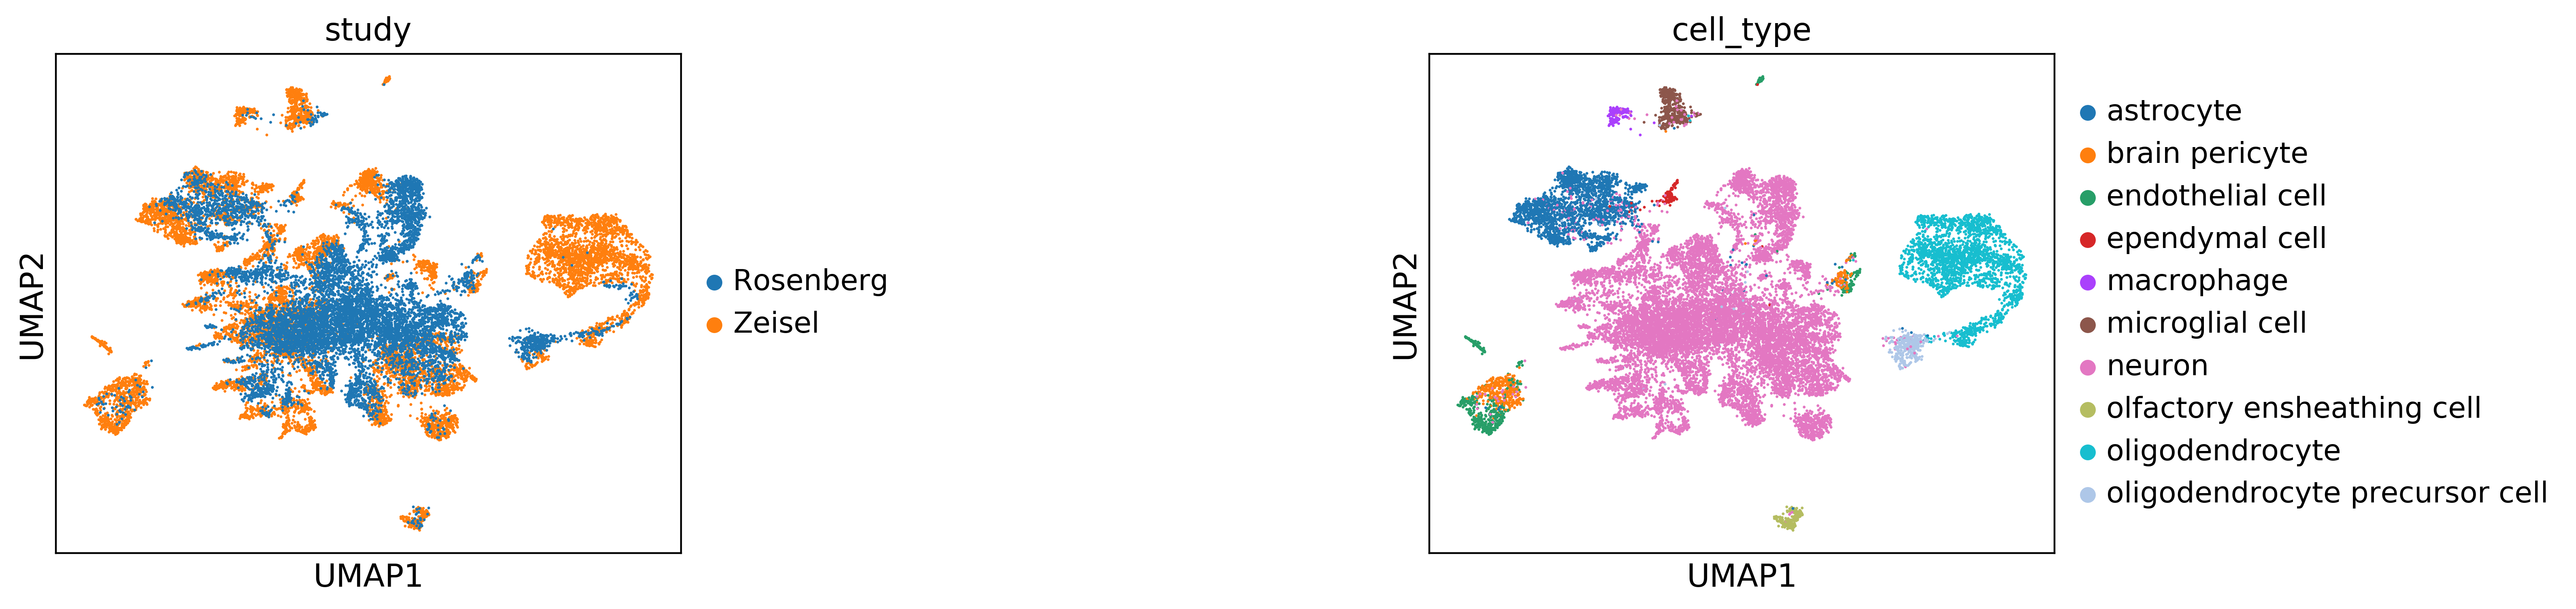

In [33]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=1.0)

In [34]:
surgeon.metrics.ari(latent_adata, cell_type_key)

0.19305305888425536

In [35]:
surgeon.metrics.nmi(latent_adata, cell_type_key)

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.537374266108356

In [36]:
surgeon.metrics.asw(latent_adata, condition_key)

0.011053815